## Filtro de medianas sobre la señal de entrada

In [18]:
import pandas as pd
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

data = pd.read_csv('~/trader/data/^GDAXI/DAX_2018_2019.csv')
data.head(3)
ts = np.array(data.Close)

def median_filter(data, window=5, num_items=0):
    if num_items == 0:
        num_items = 100
    mf = medfilt(data, window)
    plt.figure(figsize=(12,6)); 
    plt.plot(data[0:num_items], 'r--', linewidth=.5); 
    plt.plot(mf[0:num_items], 'b-', alpha=0.4, linewidth=3.)
    plt.title('Median filter window={}'.format(window))
    plt.show()

Aplicamos el filtro de medianas con ventana variable, para recoger mejor la info de tendencia, y evitar los picos. Este filtro puede ser interesante antes de entrenar las LSTMs, y para cuando estamos en producción.

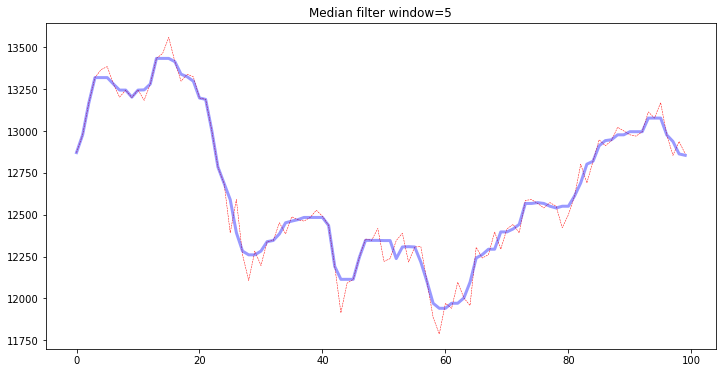

In [6]:
median_filter(ts, 5)

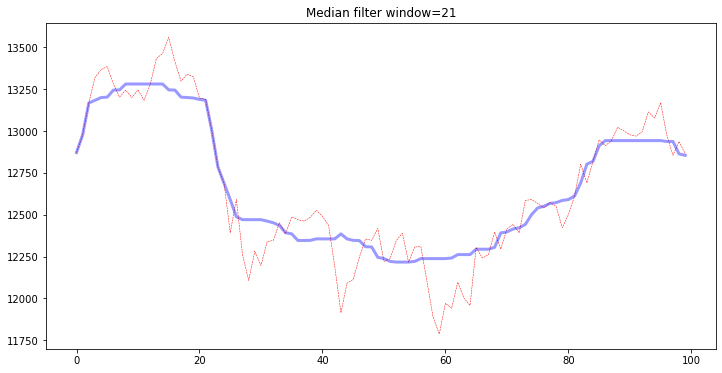

In [9]:
median_filter(ts, 21)

### Rolling window 

Aplicamos una funciona a una ventana deslizante sobre la serie temporal para ver si podemos extraer la dirección de la tendencia, como la pendiente de la recta que interpola los puntos que están dentro de la ventana. Para obtener la recta podemos hacer una regresión lineal, o calcular la correlación de Pearson.

In [63]:
def f(ser: pd.Series):
    if ser.isnull().values.any() or ser.shape[0] < 5:
        return 0.
    
    x = pd.Series([0., 1., 2., 3., 4.])
    coef = np.corrcoef(x, ser)[1,0]
    return coef


slopes = data.Close.rolling(5, min_periods=1).apply(lambda arr: f(arr), raw=False)

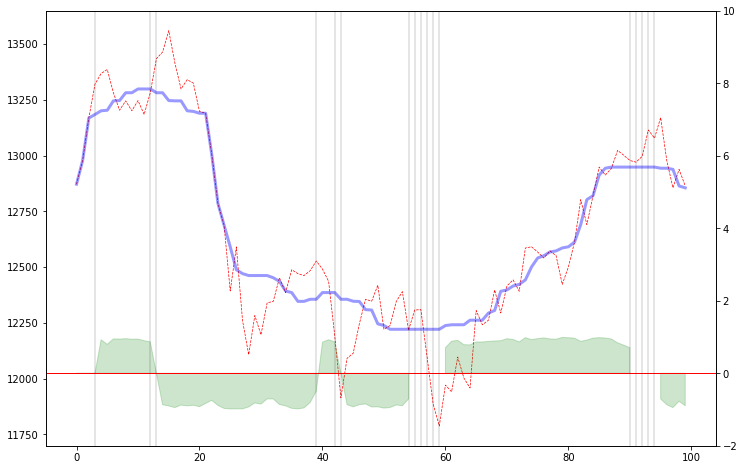

In [92]:
mf = medfilt(ts, 19)
slopes = pd.Series(mf).rolling(5, min_periods=1).apply(lambda arr: f(arr), raw=False)
zero_crossings = np.where(np.diff(np.sign(slopes[0:100])))[0]

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(ts[0:100], 'r--', linewidth=.7)
ax1.plot(mf[0:100], 'b-', alpha=0.4, linewidth=3.)

ax2 = ax1.twinx()
ax2.set_ylim(-2, 10)
ax2.fill_between(range(100), 0, slopes[0:100], color='green', alpha=0.2)
ax2.axhline(0, color='red', linewidth=1)
for x in zero_crossings:
    ax2.axvline(x, color='black', linewidth=0.2)

plt.show()

Necesito encontrar elementos consecutivos en el array de zero crossings

In [100]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

list(map(lambda arr: arr.max(), consecutive(zero_crossings)))

[3, 13, 39, 43, 59, 94]

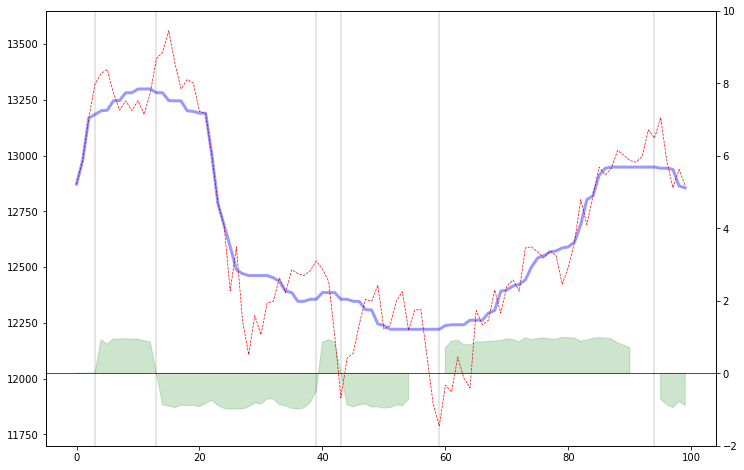

In [101]:
mf = medfilt(ts, 19)
slopes = pd.Series(mf).rolling(5, min_periods=1).apply(lambda arr: f(arr), raw=False)
zero_crossings = np.where(np.diff(np.sign(slopes[0:100])))[0]
zero_crossings = list(map(lambda arr: arr.max(), consecutive(zero_crossings)))

fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(111)
ax1.plot(ts[0:100], 'r--', linewidth=.7)
ax1.plot(mf[0:100], 'b-', alpha=0.4, linewidth=3.)

ax2 = ax1.twinx()
ax2.set_ylim(-2, 10)
ax2.fill_between(range(100), 0, slopes[0:100], color='green', alpha=0.2)
ax2.axhline(0, color='red', linewidth=1)
for x in zero_crossings:
    ax2.axvline(x, color='black', linewidth=0.2)

plt.show()